In [2]:
# add explainn subfolder to os path
import sys
sys.path.append('../../../')
from explainn import tools
from explainn import networks
from explainn import train
from explainn import test
from explainn import interpretation

import torch
import os
import json
from torch import nn
from sklearn.metrics import average_precision_score
from sklearn import metrics
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import pandas as pd
sys.path.append('../../../scripts')
from utils import (get_file_handle, get_seqs_labels_ids, get_data_loader,
                   get_device)

In [3]:
merged_tomtom_dir = "../../../../SCRATCH/AS-TAC/ExplaiNN/merged_tomtom"

In [6]:
# read the merged_tomtom_file that contains the path for each tomtom file
tomtom_file = merged_tomtom_dir + "/merged_tomtom_files.txt"
# For each path in tomtom_file, do the following
annotation_merged={}
# open the tomtom_file, but ignore the /n at the end of each line

with open(tomtom_file) as tomtom_paths:
    for tomtom_path in tomtom_paths:
        tomtom_path = tomtom_path.strip()
        tomtom_results = pd.read_csv(tomtom_path,
                                            sep="\t",comment="#")
        filters_with_min_q = tomtom_results.groupby('Query_ID').min()["q-value"]

        tomtom_results = tomtom_results[["Target_ID", "Query_ID", "q-value"]]
        tomtom_results = tomtom_results[tomtom_results["q-value"]<0.05]

        cisbp_motifs = {}
        with open("../../../../SCRATCH/downloads/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt") as f:
            for line in f:
                if "MOTIF" in line:
                    motif = line.strip().split()[-1]
                    name_m = line.strip().split()[-2]
                    cisbp_motifs[name_m] = motif

        filters = tomtom_results["Query_ID"].unique()
        annotation = {}
        for f in filters:
            t = tomtom_results[tomtom_results["Query_ID"] == f]
            target_id = t["Target_ID"]
            if len(target_id) > 5:
                target_id = target_id[:5]
            ann = "/".join([cisbp_motifs[i] for i in target_id.values])
            annotation[f] = ann

        annotation = pd.Series(annotation)
        # Get the number of units
        num = tomtom_path.split("/")
        num = num[num.index("single_train")+1]
        num = num.split("_")[0]
        annotation_merged[num]=annotation
# make a dataframe from the annotation_merged, and sort the columns by the integer are in the column names
annotation_merged = pd.DataFrame(annotation_merged)

# the columns of the annotation_merged are integers as strings. I want to sort the columns by the integer value
annotation_merged.columns = annotation_merged.columns.astype(int)
annotation_merged = annotation_merged.sort_index(axis=1)


In [7]:

annotation_merged

,20,30,50,75,100,125,400,500,600
filter0,NaN,NaN,NR2C2/RXRG/RXRB/Rxra/PPARD,NaN,NaN,NaN,NaN,NaN,NaN
filter1,CTCF/CTCF/CTCF,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
filter100,NaN,NaN,NaN,NaN,NaN,Pou5f1::Sox2/POU2F1::SOX2/SRY,NaN,RREB1/KLF4/ZNF449,NaN
filter101,NaN,NaN,NaN,NaN,NaN,FOXD3,NaN,NaN,NaN
filter107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NFYB,NaN
...,...,...,...,...,...,...,...,...,...
filter88,NaN,NaN,NaN,NaN,FOXJ2::ELF1/ELF4/ELF2/ETV2::FOXI1/ETV1,NaN,NaN,NaN,NaN
filter89,NaN,NaN,NaN,NaN,NaN,NaN,BNC2/BATF::JUN/BATF/FOSL1::JUND/BATF3,NaN,NaN
filter9,CTCF,NaN,NaN,NaN,NaN,NaN,CTCF,NaN,NaN
filter92,NaN,NaN,NaN,NaN,NaN,NaN,Pparg::Rxra/RXRG/Rxra/RXRB/PLAG1,NaN,NaN


In [8]:
#for loop the annotatin_merged and get the unique values for all the columns in the df
unique_TFs = {}
for units in annotation_merged.columns:
    values = annotation_merged[units].values
    #remove NaN values
    values = [i for i in values if str(i) != 'nan']
    split_TFs = [i.split("/") for i in values]
    #melt the list of lists
    split_TFs = [item for sublist in split_TFs for item in sublist]
    # get the unique values
    unique_TFs[units] = list(set(split_TFs))



In [9]:
#count the number of strings in the list of unique_TFs
count_TFs = {}
for units in unique_TFs.keys():
    count_TFs[units] = len(unique_TFs[units])

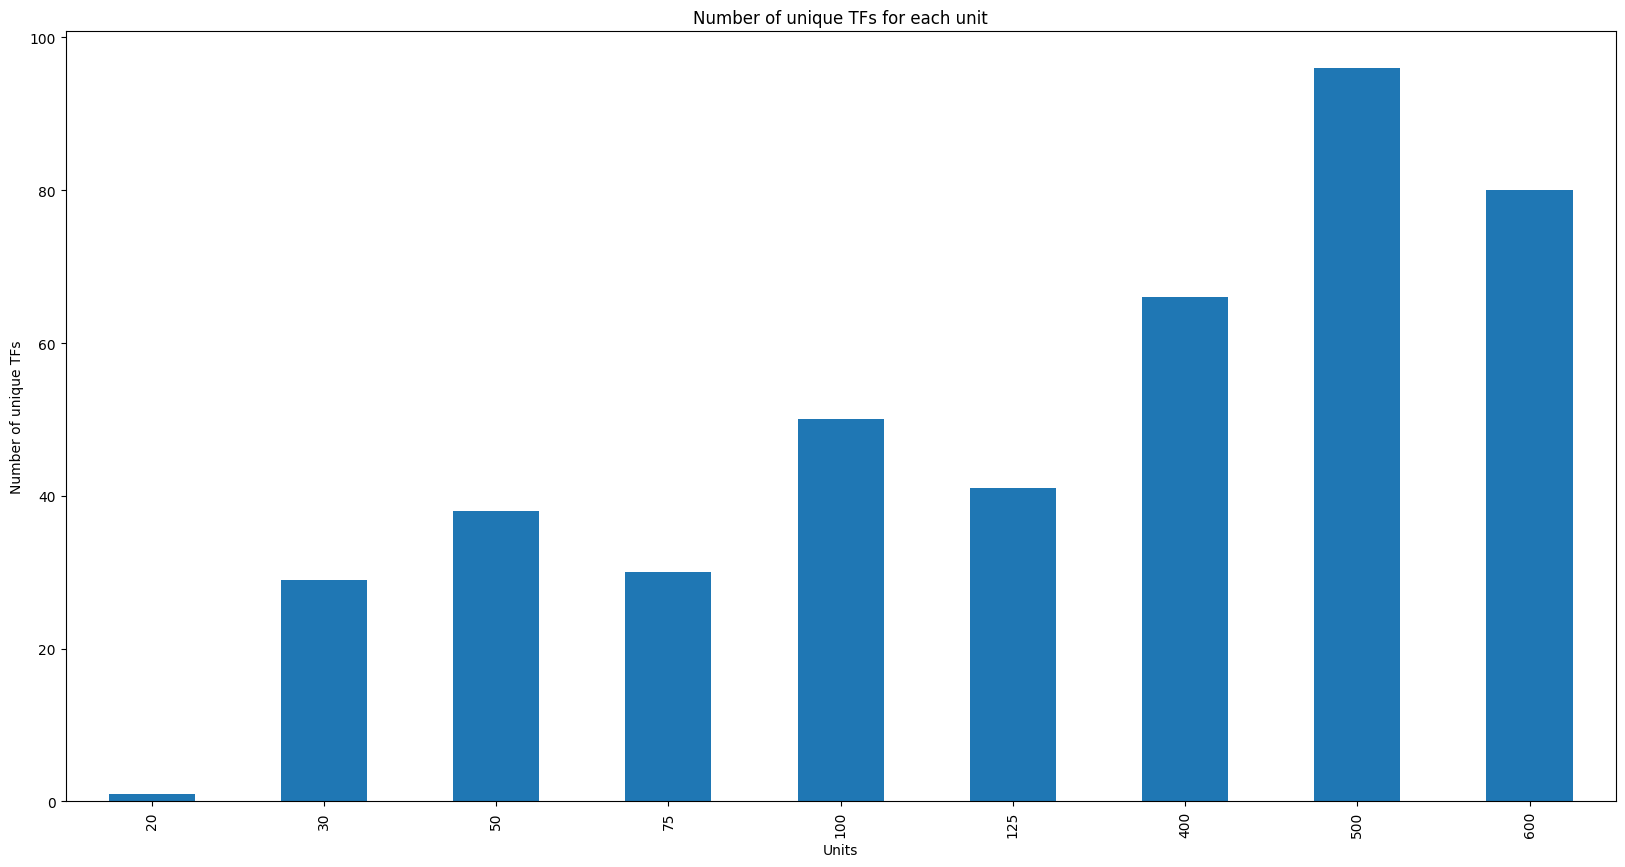

In [10]:
# make a bar plot of the count_TFs
count_TFs = pd.Series(count_TFs)
count_TFs = count_TFs.sort_index()
count_TFs = count_TFs[count_TFs>0]
count_TFs.plot(kind="bar", figsize=(20,10))
plt.xlabel("Units")
plt.ylabel("Number of unique TFs")
plt.title("Number of unique TFs for each unit")
plt.show()


In [16]:
# check chich units contain TFs that contain the word "FOX", and how many
TFs = {}
for units in unique_TFs.keys():
    TFs[units] = [i for i in unique_TFs[units] if "FOX" in i]
TFs = pd.Series(TFs)
TFs = TFs.sort_index()
TFs = TFs[TFs.apply(lambda x: len(x)>0)]
TFs


50                   [FOXC2, FOXD3, FOXB1, FOXC1, FOXA1]
100    [FOXJ2::ELF1, FOXS1, FOXB1, FOXC1, ETV2::FOXI1...
125                                              [FOXD3]
400                                       [FOXE1, FOXD2]
500    [FOXD1, FOXO6, FOXS1, FOXA2, FOXP2, FOXJ2::ELF...
600           [FOXA1, FOXI1, FOXC1, FOXO4, FOXD3, FOXP1]
dtype: object

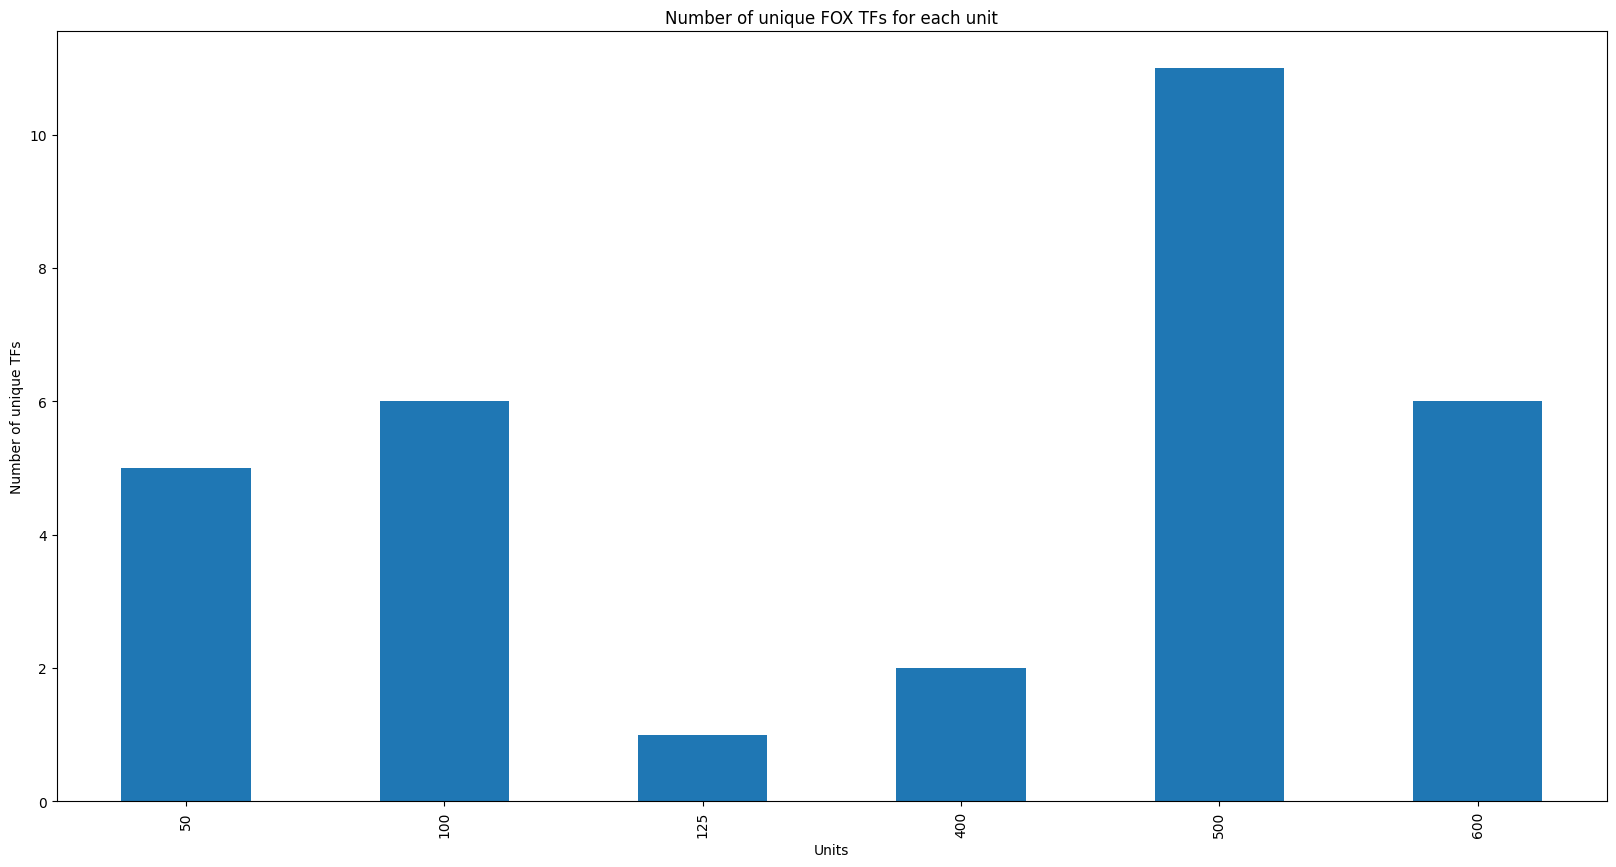

In [17]:
# make a barplot of the number of units that contain the word "FOX"
TFs_fox = pd.Series({k: len(v) for k,v in TFs.items()})
TFs_fox = TFs_fox.sort_index()
TFs_fox.plot(kind="bar", figsize=(20,10))
plt.xlabel("Units")
plt.ylabel("Number of unique TFs")
plt.title("Number of unique FOX TFs for each unit")
plt.show()
